In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../lib')

pd.set_option('display.max_columns', 500)

from datetime import datetime
from numpy import inf
from math import prod
from IPython.display import clear_output

from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from scipy.stats import kstest

# Конфиг
from model_functions import *
from model_features import *
from model_metrics import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Подготовка

#### Данные

Используем поквартальные данные по тем показателям, которые **прогнозируются Банком РФ и Минэкономразвития**

In [2]:
data=pd.read_excel('../data/data_train.xlsx',sheet_name='data')
descriptions=pd.read_excel('../data/data_train.xlsx',sheet_name='description')

#### Пропуски

In [3]:
drop_feat=[]
for c in data.columns:
    if data[c].isna().sum()>10:
        drop_feat.append(c)
        
data_model=data.drop(drop_feat,axis=1)
print(f'Удалили признаки: {drop_feat}')

Удалили признаки: ['vi_mining', 'vi_industry']


#### Лишние признаки

Удалим сальдовые признаки

In [4]:
saldo_feat=[c for c in data_model.columns if 'saldo' in c]
data_model=data_model.drop(saldo_feat,axis=1)
print(f'Удалили признаки: {saldo_feat}')

Удалили признаки: ['saldo_stp_sok', 'saldo_fin']


#### Классификация признаков

Делим признаки на три группы:
1. Процентные признаки (для них ничего делать не будем);
2. Индексные признаки (их приведём к приростам, отняв 100%);
3. Количественные признаки (для них рассчитаем приросты).

In [5]:
percent_features=['unempl_rate','int_rate']
index_features=['cpi']
count_features=[x for x in data_model.drop('period',axis=1) if x not in (percent_features+index_features)]

### 2. Генерация признаков

Все признаки и таргет приведём к темпам прироста по следующим причинам:
1. Всё будет в одном масштабе, что хорошо для линейной регрессии (она не очень терпит диспропорции в размерах данных);
2. Сохраняется интерпретация (если для унификации масштаба делать нормализацию/стандартизацию, то теряется интерпретируемость);
3. Банк РФ/Минэкономразвития тоже прогнозирует в приростах.

Затем добавим 1-е лаги признаков

#### Темпы прироста

In [6]:
data_delta=pd.DataFrame()
# Сдвигаем период на 1 вперёд
data_delta['period']=data_model['period'][1:]
# Добавляем темпы прироста
for c in data_model.drop('period',axis=1).columns:
    if c in count_features:
        data_delta[c]=(data_model[c][1:].values/data_model[c][0:-1].values-1)*100
    elif c in index_features:
        data_delta[c]=data_model[c]-100
    else:
        data_delta[c]=data_model[c]

#### Лаги

In [7]:
data_lag=pd.DataFrame()
# Сдвигаем период на 1 вперёд относительно data_delta
data_lag['period']=data_delta['period'][1:]
# Добавляем лаги
for c in data_delta.drop('period',axis=1).columns:
    data_lag[f'l1_{c}']=data_delta[c][:-1].values

#### Объединяем

In [8]:
dataset=pd.merge(data_lag,data_delta,on='period').drop(['debt_rub','l1_debt_rub'],axis=1)
# Список признаков
feature_list=dataset.drop(['period','target'],axis=1).columns
target='target'
print(f'Число наблюдений: {len(dataset)}, число признаков: {len(feature_list)}')

Число наблюдений: 54, число признаков: 29


#### Обработаем Nan и inf

In [9]:
# Обрабатываем пропуски
dataset_lr=dataset.dropna()
# Обрабатываем inf
dataset_lr.replace([np.inf, -np.inf], 0, inplace=True)
# Выводим информацию
print(f'Число наблюдений после удаления пропусков: {len(dataset_lr)}')
print(f'Начальный период: {dataset_lr["period"].min()}')
print(f'Конечный период: {dataset_lr["period"].max()}')

Число наблюдений после удаления пропусков: 46
Начальный период: 2011-04-01 00:00:00
Конечный период: 2022-07-01 00:00:00


### 3. VaR

#### Визуально оценим распределения приростов

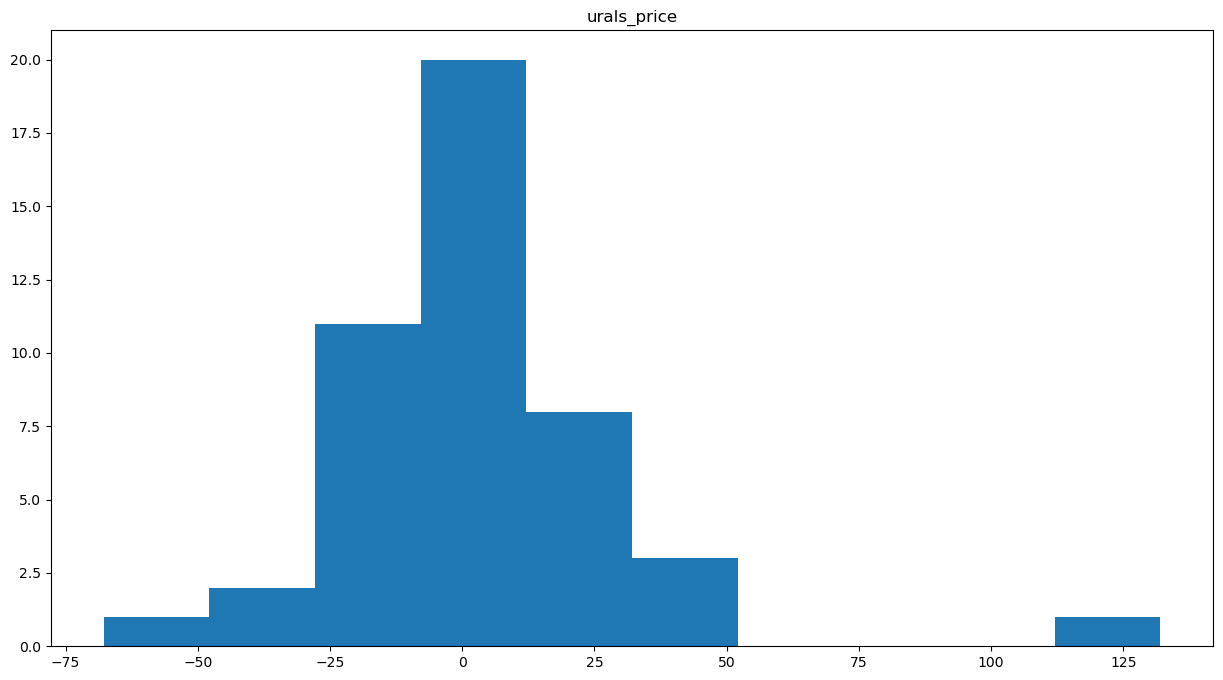

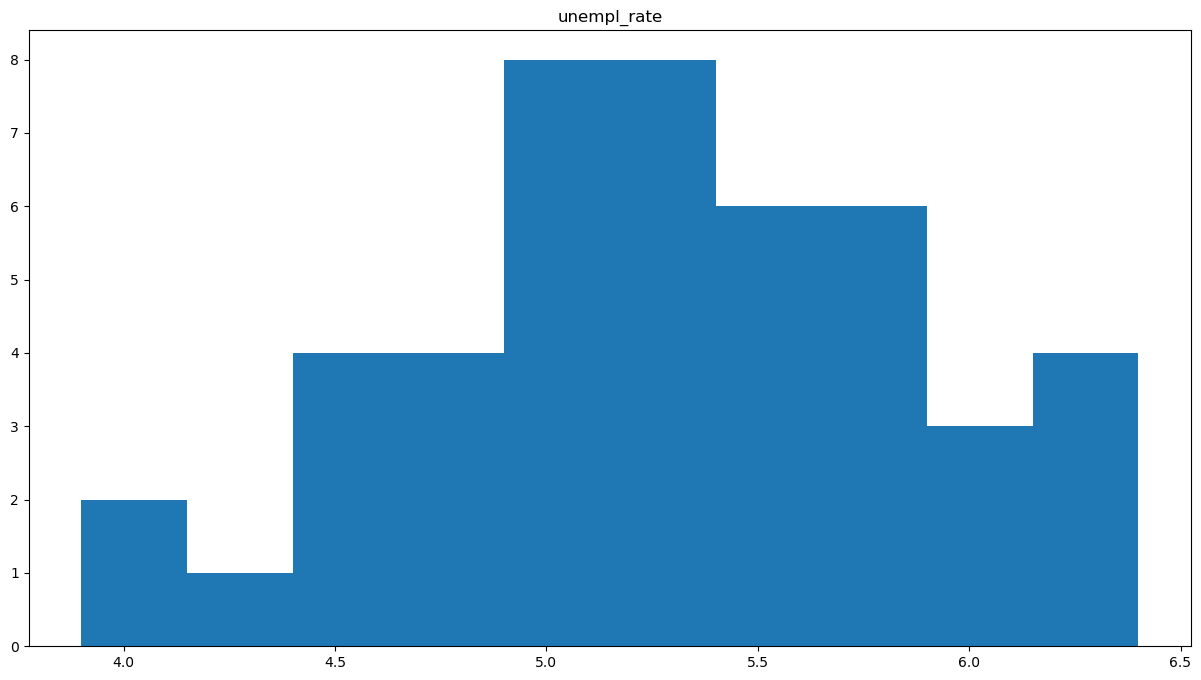

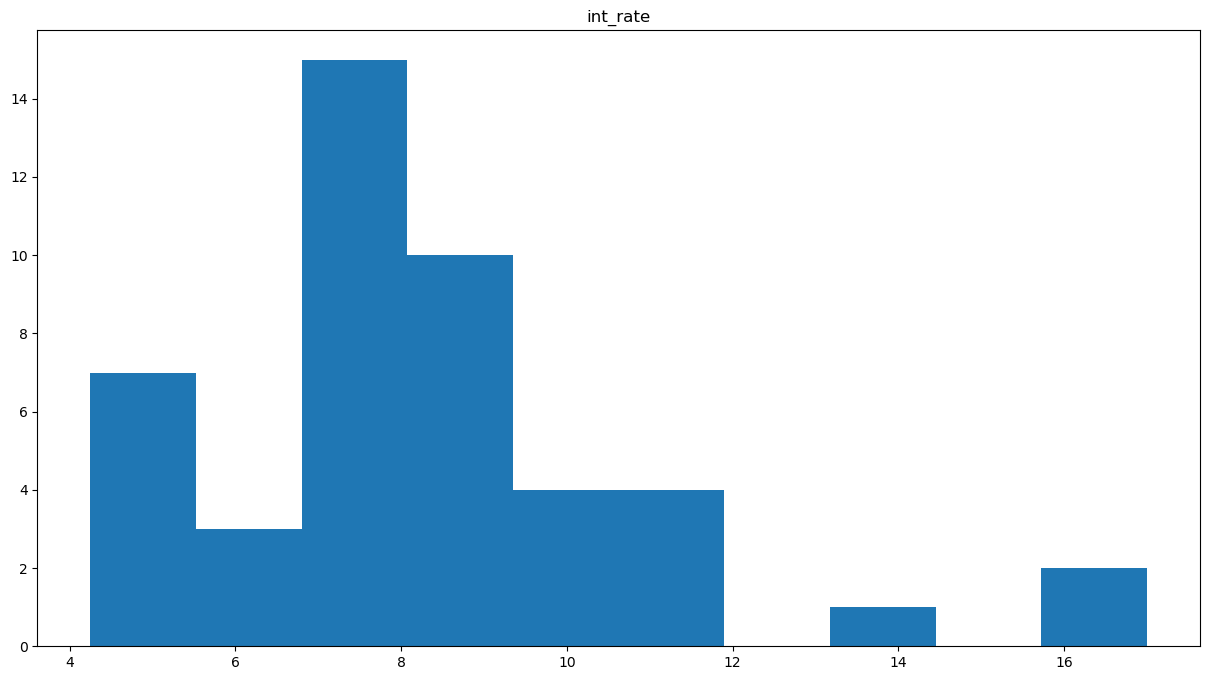

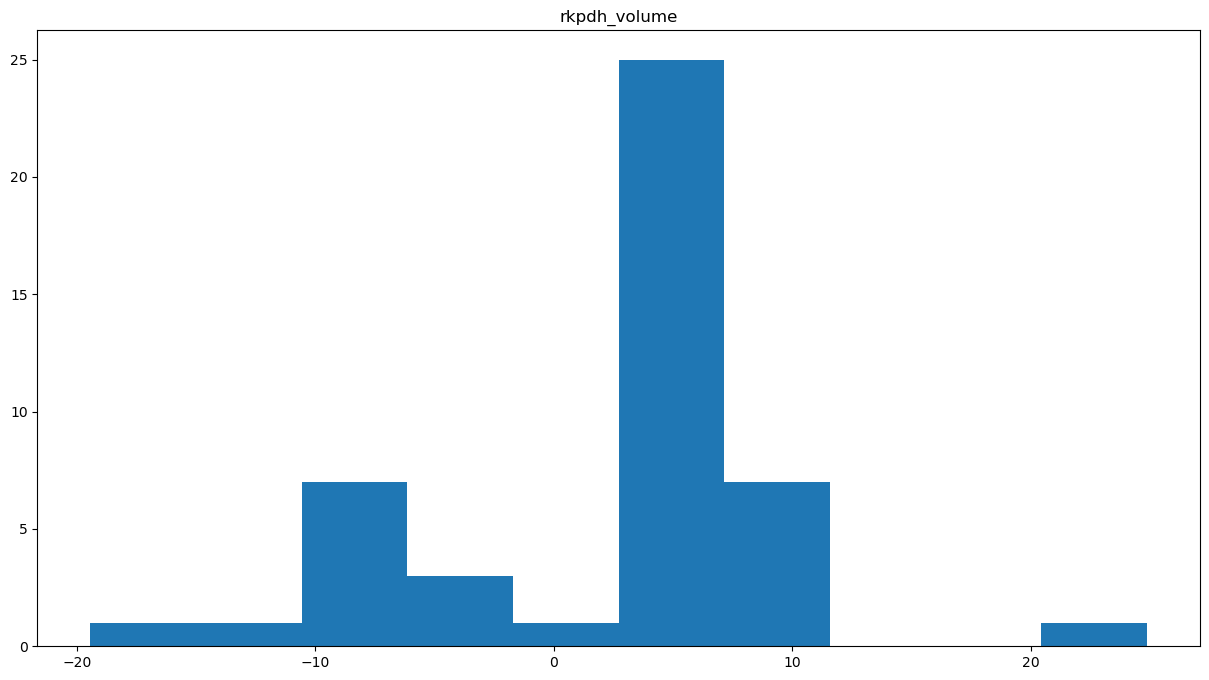

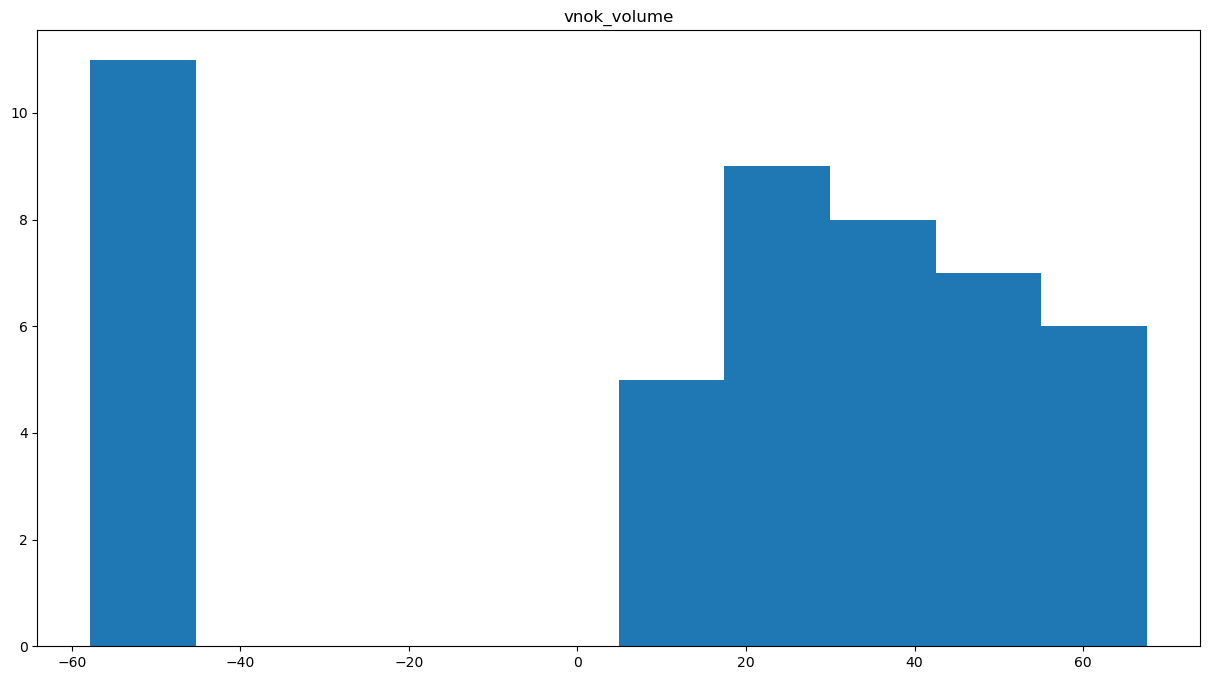

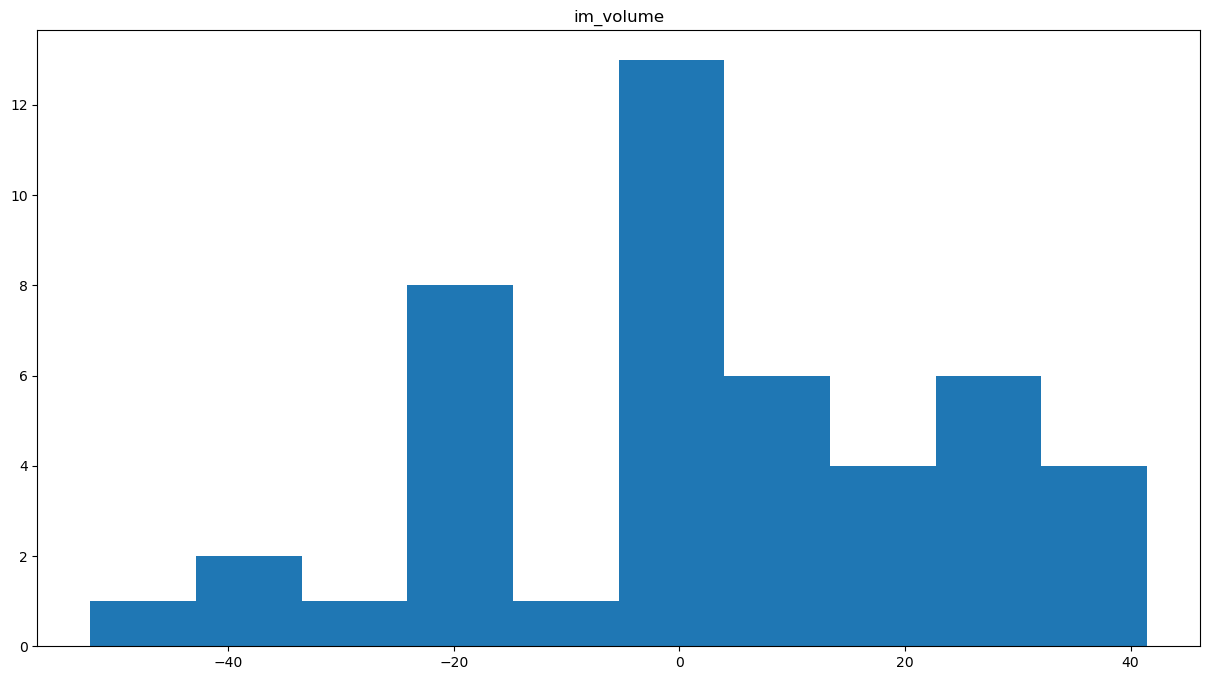

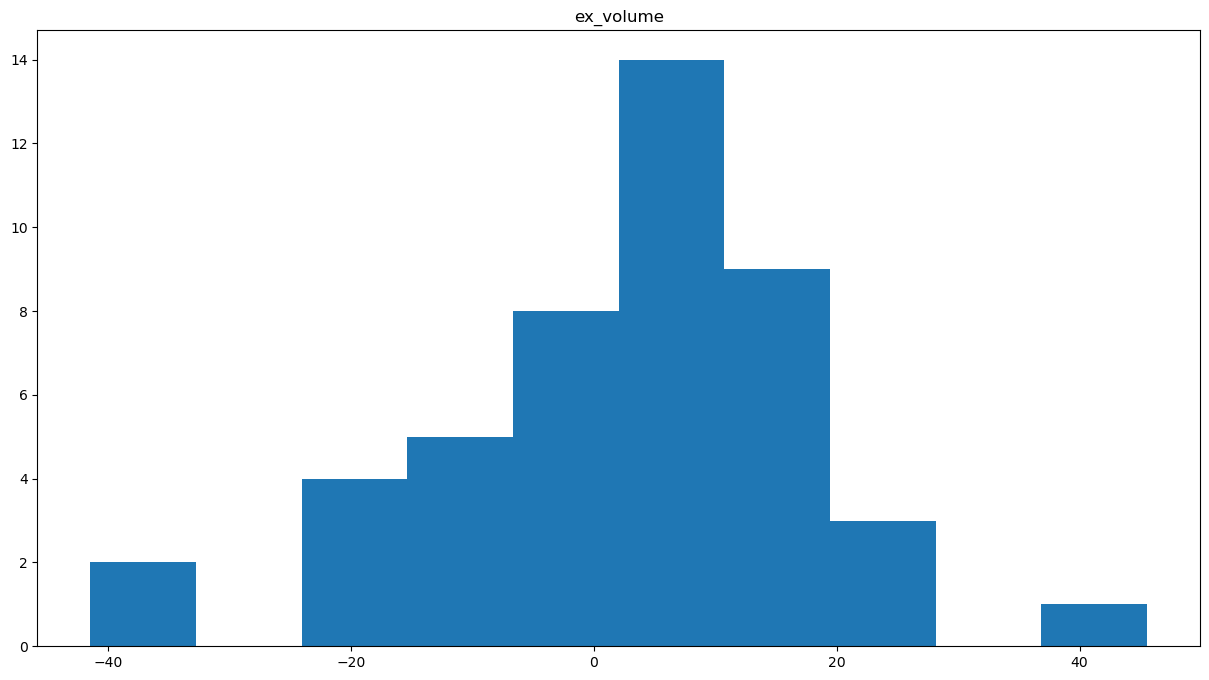

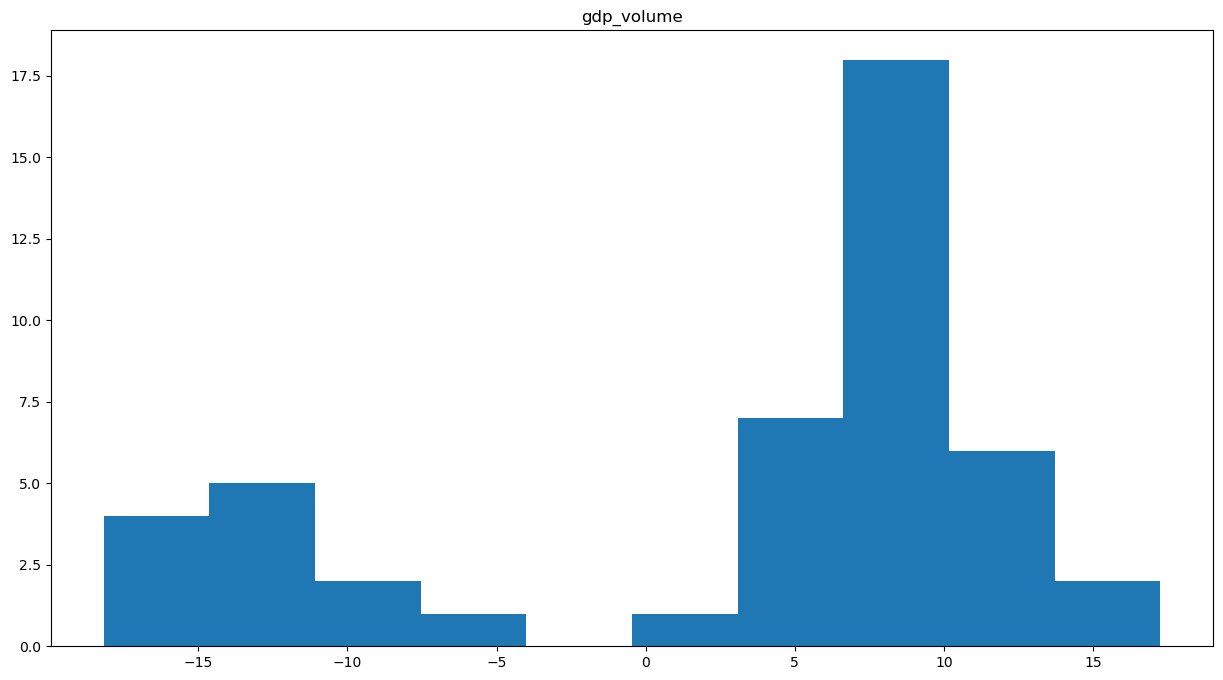

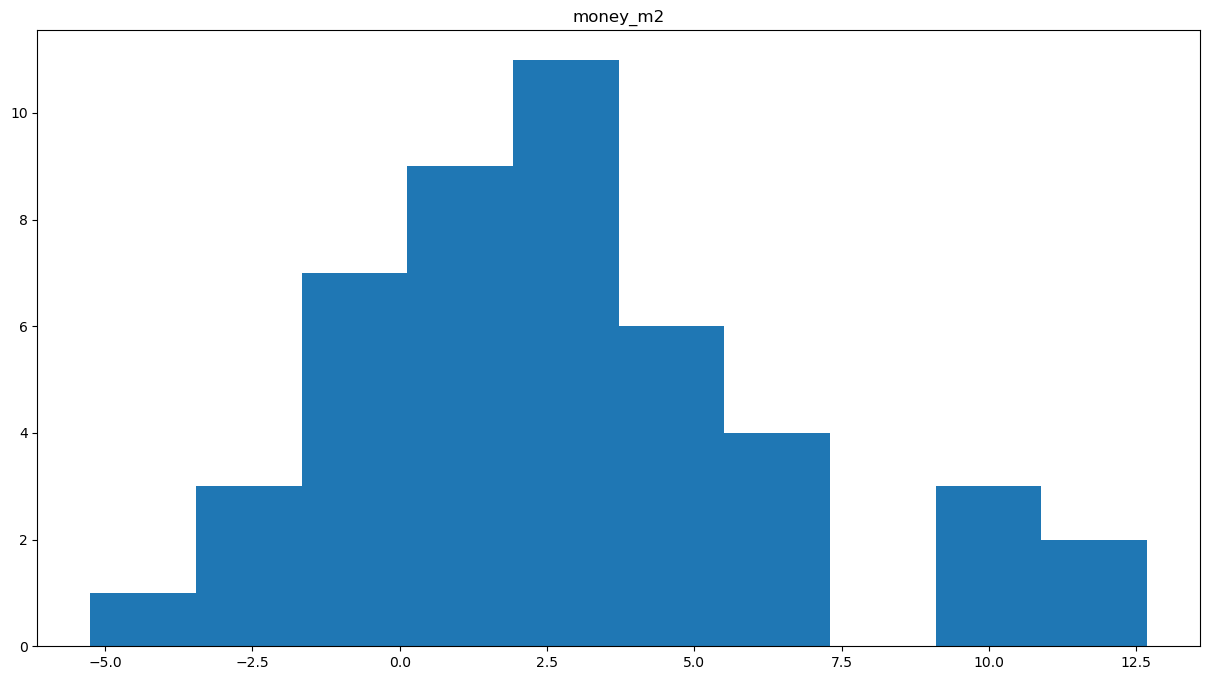

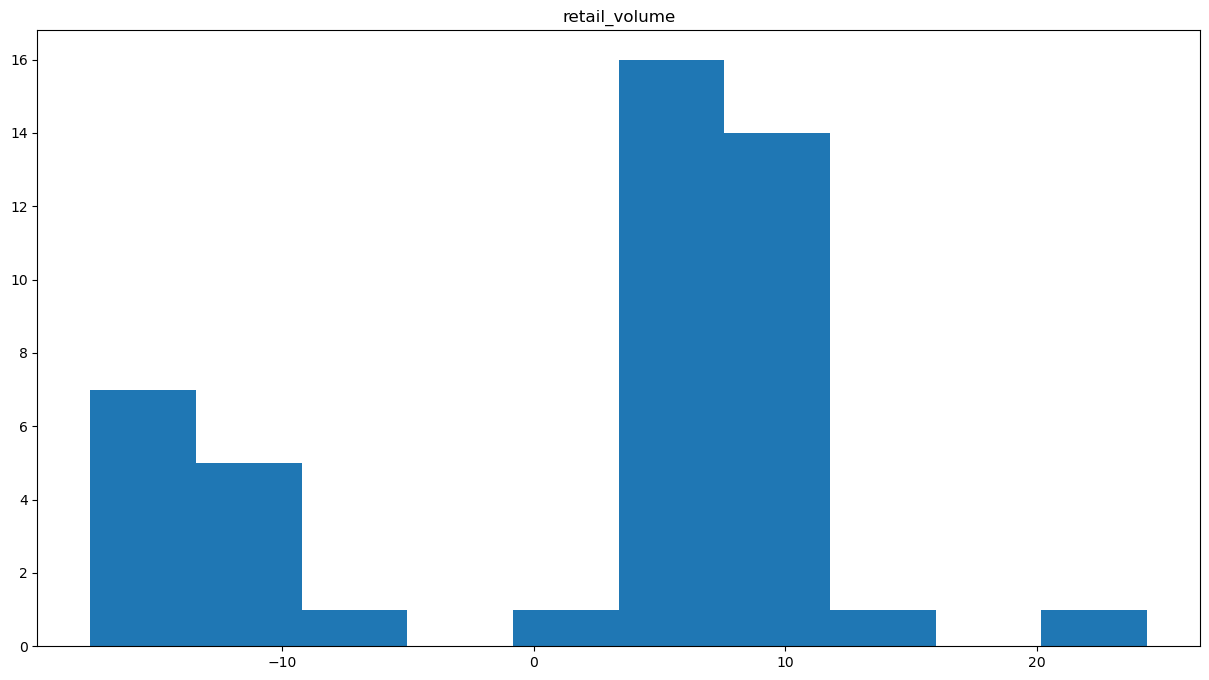

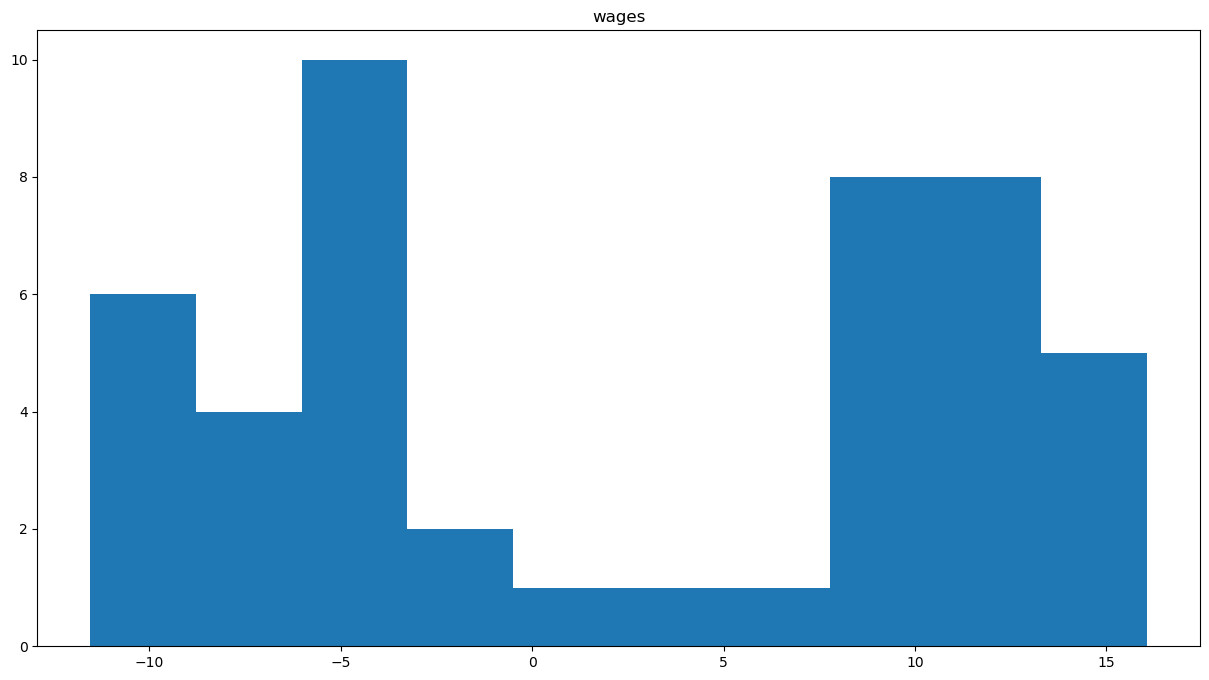

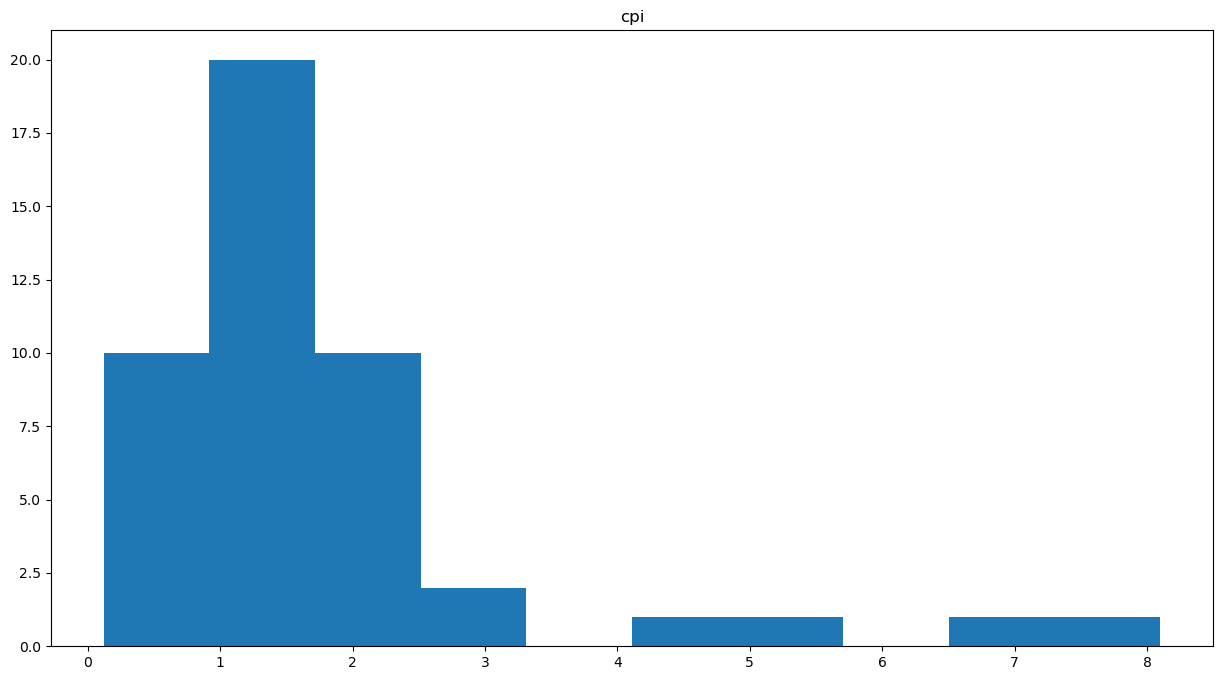

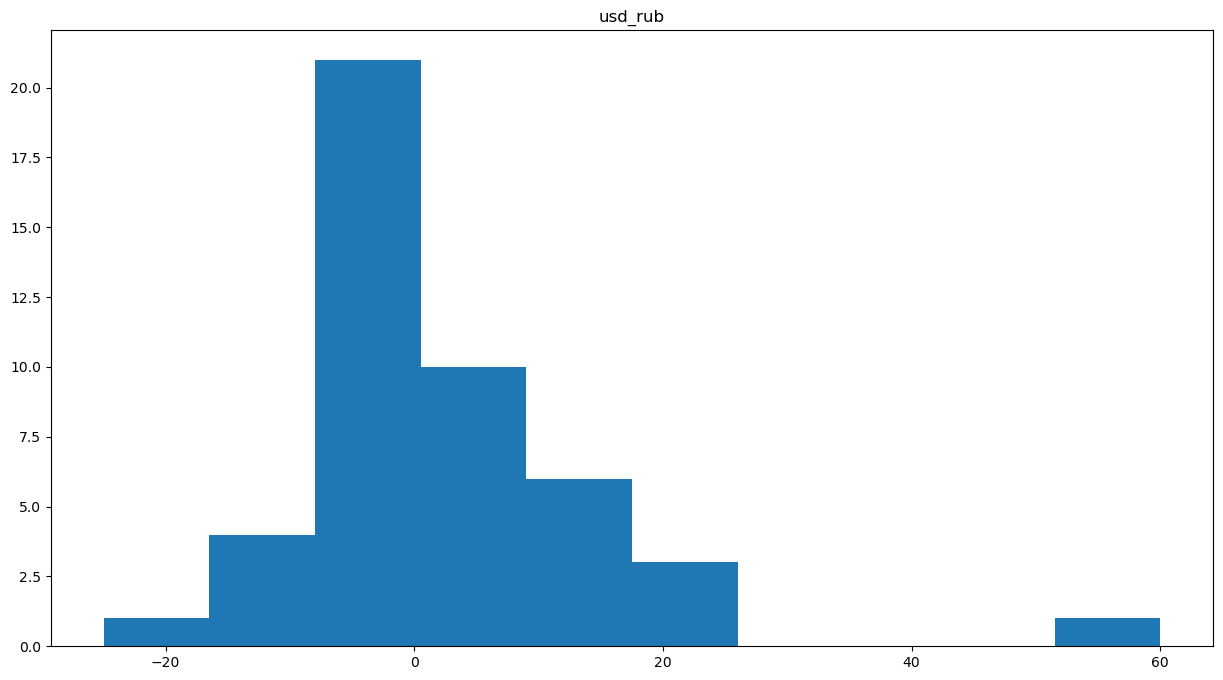

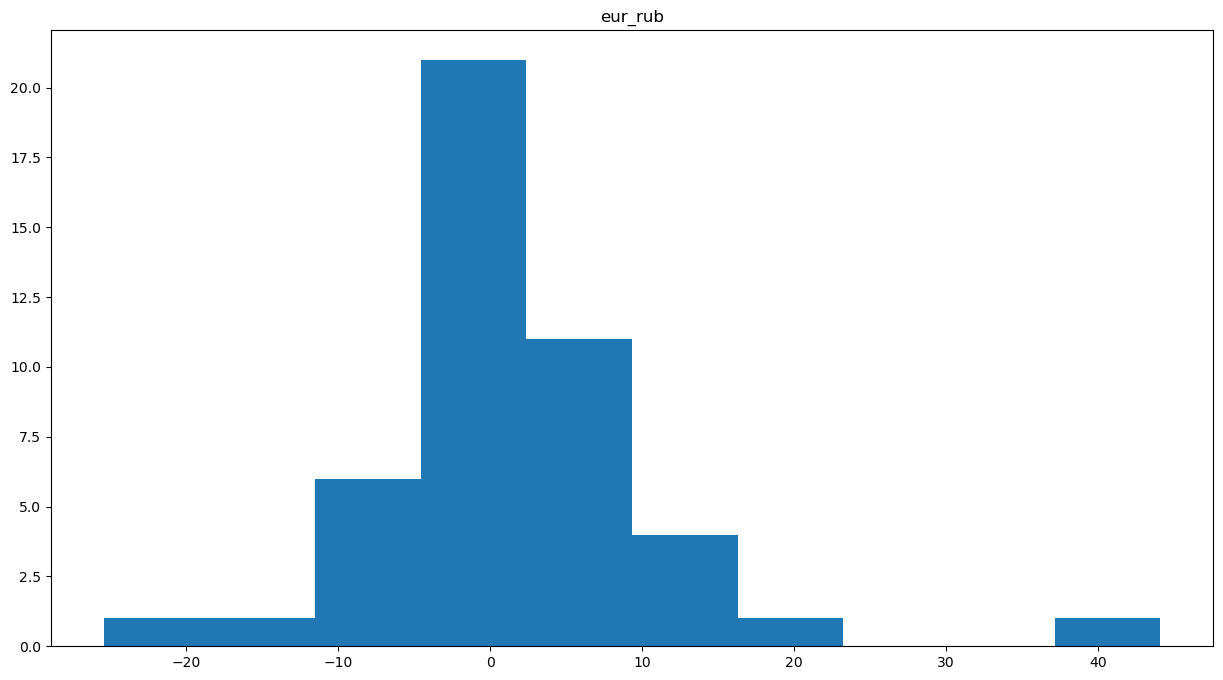

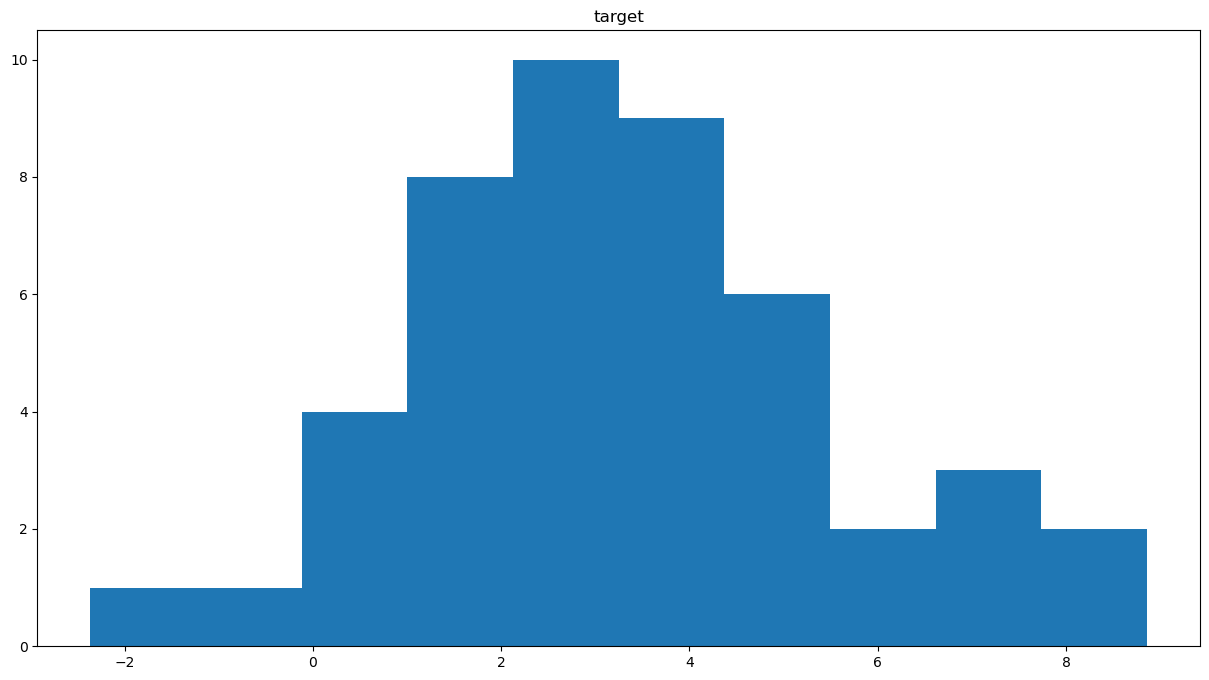

In [10]:
# Приросты макропоказателей
delta_macro=dataset_lr[[c for c in dataset_lr.columns if 'l1' not in c]]
# Графики
for c in delta_macro.drop(['period'],axis=1).columns:
    plt.figure(figsize=(15, 8))
    plt.hist(dataset_lr[c])
    plt.title(f'{c}')
    plt.show()

Где-то явно нормальное распределение, где-то придётся предположить

#### Сгенерируем для каждого признака случайные величины из нормального распределения

In [11]:
random_macro=pd.DataFrame()
# Генерация
for c in delta_macro.drop(['period'],axis=1).columns:
    random_macro[f'random_{c}']=[random.normalvariate(delta_macro[c].mean(), delta_macro[c].std()) for i in range(10000)]

#### Проведём тест Колмогорова-Смирнова на "равенство" распределений

In [14]:
for c in delta_macro.drop(['period'],axis=1).columns:
    p_value=kstest(random_macro[f'random_{c}'],delta_macro[f'{c}'])[0]
    print(f'p-value для {c} больше 0.05: {p_value>0.05}')

p-value для urals_price больше 0.05: True
p-value для unempl_rate больше 0.05: True
p-value для int_rate больше 0.05: True
p-value для rkpdh_volume больше 0.05: True
p-value для vnok_volume больше 0.05: True
p-value для im_volume больше 0.05: True
p-value для ex_volume больше 0.05: True
p-value для gdp_volume больше 0.05: True
p-value для money_m2 больше 0.05: True
p-value для retail_volume больше 0.05: True
p-value для wages больше 0.05: True
p-value для cpi больше 0.05: True
p-value для usd_rub больше 0.05: True
p-value для eur_rub больше 0.05: True
p-value для target больше 0.05: True


Для всех признаков p-value оказался больше 5%, поэтому принимаем нулевые гипотезы о "равенстве" распределений

#### Для каждого признака определяем левый и правый 5%-е хвосты

In [15]:
var_data=pd.DataFrame(columns=['feature','left_5%','right_5%'])
# Заполняем персентилями
for c in delta_macro.drop(['period'],axis=1).columns:
    left_5=np.percentile(random_macro[f'random_{c}'],5)
    right_5=np.percentile(random_macro[f'random_{c}'],95)
    var_data.loc[len(var_data)] = [c,left_5, right_5]
# Смотрим
var_data.head()

,feature,left_5%,right_5%
0,urals_price,-42.382918,48.389370
1,unempl_rate,4.251216,6.281561
2,int_rate,3.796488,12.792085
3,rkpdh_volume,-10.346971,14.992525
4,vnok_volume,-54.279197,84.767262


#### Сохраняем

In [17]:
var_data.to_excel('../results/VaR.xlsx',index=0)